Installing necessary prereqs: [NetworkX](https://networkx.org/documentation/stable/reference/index.html) for graphing, [PuLP](https://coin-or.github.io/pulp/main/index.html) for linear programming.

In [36]:
%pip install networkx pulp

Note: you may need to restart the kernel to use updated packages.


In [37]:

import json
import networkx as nx

file = open("map_nh.json")
data = json.load(file)

adjacencies = data["adj"]
countyNames = data["county"]
pop = data["pop"]

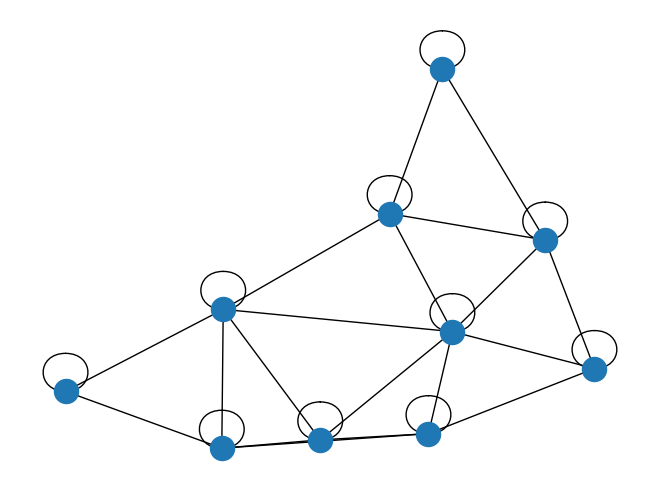

In [38]:
from random import Random

stateGraph = nx.Graph()

r =  Random(51535162)
totalPop = 0
# Add the nodes as necessary

for i in range(0, len(adjacencies)):
    # Adds node for each set of adjacencies
    stateGraph.add_node(countyNames[i], weight=pop[i])
    totalPop += pop[i]
    # Adds necessary edges; double-adding doesn't matter
    for j in adjacencies[i]:
        # Add edge with uniformly random weight 0, 10
        stateGraph.add_edge(countyNames[i], countyNames[j], weight=r.uniform(0, 10))

nx.draw(stateGraph)

In [39]:
# Number of districts
NUM_DISTRICTS = 2

# Population Tolerance
ALPHA = .05

# Population per district
targetPop = totalPop / NUM_DISTRICTS

# Binary indicators, defined as 1 if in node in same partitition as 
# source S or 0 in same as sink O. Initializes to 0.
V = [0 for i in range(stateGraph.order())]

# 
Y = [[0 for i in range(stateGraph.order())] for j in range(stateGraph.order())]


In [40]:
import pulp 

def CutPartition(remainingGraph):
    prog = pulp.LpProblem("CutPartition", pulp.LpMinimize)

    # Defining Partition Binary
    xVars = []
    xVarMap = {}
    for n in remainingGraph.nodes:
        var = pulp.LpVariable("x" + n, cat=pulp.LpBinary)
        xVarMap[n] = var
        xVars.append(var)
        prog += var
    # Defining crossing binary
    edgeVars = []
    weights = []
    for n, m in remainingGraph.edges:
        edgeVal = pulp.LpAffineExpression([(xVarMap[n], 1), (xVarMap[m], -1)])
        absEdgeVal = pulp.LpVariable('y' + n + m, cat=pulp.LpBinary)

        # Tries to fix absolute value prob
        prog += absEdgeVal >= edgeVal
        prog += absEdgeVal >= -edgeVal

        edgeVars.append(absEdgeVal)
        weights.append(remainingGraph[n][m]['weight'])
    # Subset sum
    popVariables = []
    for i in range(len(xVars)):
        popVariables.append(pulp.LpAffineExpression(xVars[i] * pop[i]))
    # Max Pop
    prog += pulp.lpSum(popVariables) <= targetPop * (1 + ALPHA)
    # Min Pop
    prog += pulp.lpSum(popVariables) >= targetPop * (1 - ALPHA)

    # Define Minimization Target
    # Edgeweights
    edgeWeightVars = []
    for i in range(len(edgeVars)):
        edgeWeightVars.append(pulp.LpAffineExpression(edgeVars[i] * weights[i]))
    prog += pulp.LpAffineExpression(pulp.lpSum(edgeWeightVars), name="Z")

    prog.solve()

    toReturn = {}

    districtPop = 0
    for i in range(len(xVars)):
        if(xVars[i].value() == 1):
            districtPop += pop[i]
            toReturn[xVars[i].name] = xVars[i].value()
            print(xVars[i].name, xVars[i].value())
    print(districtPop)
    return toReturn

In [41]:
remainingGraph = stateGraph.copy()
districts = []
while len(districts) < NUM_DISTRICTS - 1:
    cutResult = CutPartition(remainingGraph)
    newDistrict = []
    for d in cutResult.keys():
        # Gets rid of the x
        newDistrict.append(d[1:])
    # Appends the new district to our list of districts
    districts.append(newDistrict)
    # Removes those nodes from the district
    remainingGraph.remove_nodes_from(newDistrict)
    print(newDistrict)
districts.append(remainingGraph)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/6a6e96b9156f455bbcfc6bbdb46e814b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/z3/3qb7cv41693fmz3b6hbntjkr0000gn/T/6a6e96b9156f455bbcfc6bbdb46e814b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 65 COLUMNS
At line 347 RHS
At line 408 BOUNDS
At line 448 ENDATA
Problem MODEL has 60 rows, 39 columns and 174 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.04

xBelknap_County 1.0
xStrafford_County 1.0
xGrafton_County 1.0
xCheshire_County 1.0
xHillsborough_County 1.0
xRockingham_C

In [42]:
import csv

file = open('nh_districts.csv', 'w')
w = csv.writer(file)
w.writerows(districts)
file.close()